Changelog:
1. Same as V11
2. stricter psuedo-label selection
3. training without english samples
4. triangular cyclical learning rates
5. Lang added to Text
6. Frozen Tranformers Model's Output (for performance gains)

# Settings

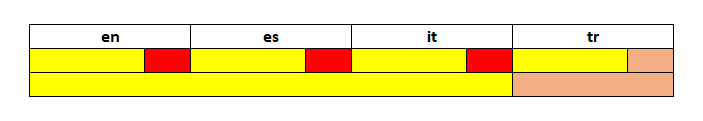

In [1]:
# CONTROLS
MODEL_PREFIX = "V12"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = ['xlm', 'xlm-large', 'distilbert'][0]; print(MODEL_NAME);

NUM_EPOCHS = [32, 32]
NUM_FOLDS = 5
MIN_LR = 1e-7
MAX_LR = 1e-3
STEP_SIZE = 2
MAX_SEQ_LEN = 128
SAMPLE_SIZE = 6000
PSUEDO_QUANTILE_THRESH_HIGH = 0.98
PSUEDO_QUANTILE_THRESH_LOW = 0.02

RUN_ON_SAMPLE = 0
if RUN_ON_SAMPLE>0:
    SAMPLE_SIZE = RUN_ON_SAMPLE

ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 32
    PREDICT_BATCH_SIZE = 512
else:
    BATCH_SIZE = 32
    PREDICT_BATCH_SIZE = 512

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.1

xlm


In [2]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".."
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    elif MODEL_NAME == 'xlm-large':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-large-base/"
    elif MODEL_NAME == 'distilbert-large':
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased-large/"
    elif MODEL_NAME == 'distilbert':
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"
    else:
        print("No Model selected")
        pass

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 987258
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Mon Jun 22 23:51:35 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.2.0', '2.11.0', '0.7.0']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [10]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [12]:
validation.lang.unique(), test.lang.unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([validation[REQ_COLS]], axis=0)

1. XLM-RoBerta uses these special tokens "sep_token": "\</s\>", "pad_token": "\<pad\>", "cls_token": "\<s\>"
2. Distilbert uses these special tokens "sep_token": "[SEP]", "pad_token": "[PAD]", "cls_token": "[CLS]"

In [17]:
languages = {
    'en':' english ',
    'tr':' turkish ',
    'ru':' russian ',
    'it':' italian ',
    'fr':' french ',
    'pt':' portuguese ',
    'es':' spanish ',
}

if MODEL_NAME == 'xlm':
    data['text'] = data['lang'].apply(lambda x:languages[x]) + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x]) + test['text']
elif MODEL_NAME == 'xlm-large':
    data['text'] = data['lang'].apply(lambda x:languages[x]) + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x]) + test['text']
elif MODEL_NAME == 'distilbert-large':
    data['text'] = data['lang'].apply(lambda x:languages[x])  + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x])  + test['text']
elif MODEL_NAME == 'distilbert':
    data['text'] = data['lang'].apply(lambda x:languages[x])  + data['text']
    test['text'] = test['lang'].apply(lambda x:languages[x])  + test['text']
else:
    print("Nothing Done")

In [18]:
data.shape

(8000, 5)

In [19]:
data.sample(2)

,id,set,text,lang,toxic
4153,4153,valid,turkish İşte ben de diyorum ki Türkçede farklı bir ada sahip olmadığını iddia ediyorsanız muhtemelen konu ilgi alanınızda değil. Kişisel itham olarak algılamayın bir olasılık olarak söylüyorum. Konuya dair yakın dönem Türkçe hangi kaynağa bakarsanız bakın Kobane/Kobani görürsünüz. Kud yaz,tr,0
2736,2736,valid,"italian Continuo anch io a pensare che la frase rispecchia perfettamente il pensiero di Odifreddi, che è quello di cui parla la voce su Odifreddi. Se la voce Adolf Hitler iniziasse con la citazione gli ebrei sono dei parassiti nel corpo delle altre nazioni ci sarebbero gli stessi problemi? .mau. ✉",it,0


In [20]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [21]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [22]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [23]:
# print("**Sample Text**")
# t = data['text'][0]
# encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
# decoded_tokens = xlmr_tok.decode(encoded_text['input_ids'])
# print(t)
# print("**Encoded Tokens**")
# print(encoded_text['input_ids'], sep=",")
# print("**Decoded Tokens**")
# print(decoded_tokens)

In [24]:
MODEL_INFERENCE_BATCHSIZE = {
    'xlm' : 128,
    'distilbert' : 256,
    'xlm-large' : 128
}

In [25]:
def find_model_path(MODEL_NAME):
    PATH = ".."
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    elif MODEL_NAME == 'xlm-large':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-large-base/"
    elif MODEL_NAME == 'distilbert-large':
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased-large/"
    elif MODEL_NAME == 'distilbert':
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"
    else:
        print("No Model selected")
        pass
    return MODEL_DIR

In [26]:
def prepare_data(MODEL_NAME):
    
    MODEL_DIR = find_model_path(MODEL_NAME)

    print("Loading Tokenizer")
    if MODEL_NAME == 'xlm':
        xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
    elif MODEL_NAME == 'xlm-large':
        xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
    elif MODEL_NAME == 'distilbert-large':
        xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)
    elif MODEL_NAME == 'distilbert':
        xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)
    else:
        print("No tokenizer Selected")

    print("Tokenization on Training Set")
    X_tokens, X_att = [], []
    for n, t in enumerate(tqdm(data.text.tolist())):
        encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
        X_tokens.append(encoded_text['input_ids'])
        X_att.append(encoded_text['attention_mask'])

    X_tokens, X_att = np.array(X_tokens, dtype=np.int32), np.array(X_att, dtype=np.int32)
    X_tokens, X_att, X_lang, Y_toxic = X_tokens, X_att, data['lang'].values, data['toxic'].values

    print("Tokenization on Test Set")
    X_tokens_test, X_att_test = [], []
    for n, t in enumerate(tqdm(test.text.tolist())):
        encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
        X_tokens_test.append(encoded_text['input_ids'])
        X_att_test.append(encoded_text['attention_mask'])
    
    X_tokens_test, X_att_test = np.array(X_tokens_test, dtype=np.int32), np.array(X_att_test, dtype=np.int32)
    X_tokens_test, X_att_test, X_lang_test = X_tokens_test, X_att_test, test['lang'].values
    return (X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test, X_lang_test)

In [29]:
def extract_features(MODEL_NAME, BATCH):
    
    MODEL_DIR = find_model_path(MODEL_NAME)
    
    input_tokens = Input((MAX_SEQ_LEN), name="input_tokens", dtype=tf.int32)
    input_atts = Input((MAX_SEQ_LEN), name="input_atts", dtype=tf.int32)
    
    print("Loading Model", MODEL_NAME)
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config)
    elif MODEL_NAME == 'xlm-large':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config)
    elif MODEL_NAME == 'distilbert-large':
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR, config=config)
    elif MODEL_NAME == 'distilbert':
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        base_model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR, config=config)
    else:
        print("No Model Chosen")
    
    if MODEL_NAME=='distilbert':
        o1 = base_model(inputs=input_tokens, attention_mask=input_atts)[0]
    else:
        o1, o2 = base_model(inputs=input_tokens, attention_mask=input_atts)
    
    model = Model([input_tokens, input_atts], o1)
    
    X_inputs = model.predict([X_tokens, X_att], batch_size=BATCH)
    X_inputs_test = model.predict([X_tokens_test, X_att_test], batch_size=BATCH)
    
#     NUM_BATCHES = np.int(np.ceil(len(X_tokens)/BATCH))
#     print("There are", NUM_BATCHES, "Batches in Training Data")
#     for n, (t, a) in enumerate(tqdm(zip(np.array_split(X_tokens, NUM_BATCHES),
#                                         np.array_split(X_att, NUM_BATCHES)), total=NUM_BATCHES)):
#         if MODEL_NAME=='distilbert':
#             o1 = base_model(inputs=t, attention_mask=a)[0]
#         else:
#             o1, o2 = base_model(inputs=t, attention_mask=a)
#         if n==0:
#             X_inputs = np.array(o1)
#             print(X_inputs.shape)
#         else:
#             X_inputs = np.concatenate((X_inputs, np.array(o1)))
    
#     X_inputs = np.array(X_inputs)

#     NUM_BATCHES = np.int(np.ceil(len(X_tokens_test)/BATCH))
#     print("There are", NUM_BATCHES, "Batches in Testing Data")
#     for n, (t, a) in enumerate(tqdm(zip(np.array_split(X_tokens_test, NUM_BATCHES),
#                                         np.array_split(X_att_test, NUM_BATCHES)), total=NUM_BATCHES)):
#         if MODEL_NAME=='distilbert':
#             o1 = base_model(inputs=t, attention_mask=a)[0]
#         else:
#             o1, o2 = base_model(inputs=t, attention_mask=a)
#         if n==0:
#             X_inputs_test = np.array(o1)
#             print(X_inputs_test.shape)
#         else:
#             X_inputs_test = np.concatenate((X_inputs_test, np.array(o1)))

#     X_inputs_test = np.array(X_inputs_test)

    del config
    del base_model
    del model
    gc.collect()
    K.clear_session()

    return (X_inputs, X_inputs_test)

In [ ]:
MODEL_NAME = 'distilbert'
X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test, X_lang_test = prepare_data(MODEL_NAME)

In [30]:
X_distilbert_inputs, X_distilbert_inputs_test = extract_features(MODEL_NAME=MODEL_NAME,
                                                                 BATCH = MODEL_INFERENCE_BATCHSIZE[MODEL_NAME])

print("\n**",MODEL_NAME,"**",
      "\n**Training Set Inputs**\n",
      X_tokens.shape, "\t: X_tokens ", "\n",
      X_att.shape, "\t: X_att ", "\n",
      X_lang.shape, "\t: X_lang ", "\n",
      Y_toxic.shape, "\t: Y_toxic ", "\n",
      "\n**Training Set Outputs**\n",
      X_distilbert_inputs.shape, "\t: X_distilbert_inputs ", "\n",          
      "\n**Test Set Inputs**\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n",
      X_lang_test.shape, "\t: X_lang_test ", "\n"
      "\n**Test Set Outputs**\n",
      X_distilbert_inputs_test.shape, "\t: X_distilbert_inputs_test ", "\n",  
)

Loading Model distilbert


ResourceExhaustedError:  OOM when allocating tensor with shape[256,128,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/tf_distil_bert_model_1/distilbert/transformer/layer_._1/ffn/activation_14/truediv (defined at /anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/transformers/modeling_tf_distilbert.py:53) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_8508]

Errors may have originated from an input operation.
Input Source operations connected to node model/tf_distil_bert_model_1/distilbert/transformer/layer_._1/ffn/activation_14/truediv:
 model/tf_distil_bert_model_1/distilbert/transformer/layer_._1/ffn/lin1/BiasAdd (defined at /anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/transformers/modeling_tf_distilbert.py:280)

Function call stack:
predict_function


In [ ]:
MODEL_NAME = 'xlm'
X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test, X_lang_test = prepare_data(MODEL_NAME)
X_xlm_inputs, X_xlm_inputs_test = extract_features(MODEL_NAME=MODEL_NAME,
                                                   BATCH = MODEL_INFERENCE_BATCHSIZE[MODEL_NAME])

print("\n**",MODEL_NAME,"**",
      "\n**Training Set Inputs**\n",
      X_tokens.shape, "\t: X_tokens ", "\n",
      X_att.shape, "\t: X_att ", "\n",
      X_lang.shape, "\t: X_lang ", "\n",
      Y_toxic.shape, "\t: Y_toxic ", "\n",
      "\n**Training Set Outputs**\n",
      X_xlm_inputs.shape, "\t: X_xlm_inputs ", "\n",          
      "\n**Test Set Inputs**\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n",
      X_lang_test.shape, "\t: X_lang_test ", "\n"
      "\n**Test Set Outputs**\n",
      X_xlm_inputs_test.shape, "\t: X_xlm_inputs_test ", "\n",  
)

# Model Specification

In [ ]:
def build_model():
    distilbert_features = Input((MAX_SEQ_LEN, X_distilbert_inputs.shape[2]), name="distilbert_features")
    x1 = tf.keras.layers.Conv1D(X_distilbert_inputs.shape[2], 2, padding='same')(distilbert_features)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dropout(DROPOUT)(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    
    xlm_roberta_features = Input((MAX_SEQ_LEN, X_xlm_inputs.shape[2]), name="xlm_roberta_features")
    x2 = tf.keras.layers.Conv1D(X_xlm_inputs.shape[2], 2, padding='same')(xlm_roberta_features)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dropout(DROPOUT)(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    
    x_concat = tf.keras.layers.concatenate([x1, x2])
    toxic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='toxic_output')(x_concat)
    
    model = Model([distilbert_features, xlm_roberta_features],
                  [toxic_output])
    
    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

# Cross Validation Strategy

KFold train-validation split

In [ ]:
kf = KFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [ ]:
pred_df = data[['id']]
pred_df_test = test[['id']]
timings_dict = {}
cv_stats = {}
MODEL_NAME = "2Combined"

In [ ]:
for num, (t_index, v_index) in enumerate(kf.split(X_tokens, Y_toxic)):
    print("[INFO] ==================== FOLD#", num, "====================")
    
    start_time = time()

    if num>0:
        del model
        del mcp
        del csvl
        del adam
        del history
        del auc
        del tclr
        gc.collect()
        K.clear_session()

    model = build_model()
    auc = tf.keras.metrics.AUC(name='auc')
    mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+"_"+MODEL_NAME+"_"+MODEL_PREFIX+".h5",
                          monitor='val_auc', verbose=0, save_best_only=True, save_weights_only=True,
                          mode='max', save_freq='epoch')
    csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_"+str(num)+"_LossLogs_"+MODEL_NAME+"_"+MODEL_PREFIX+".csv",
                     separator=",", append=True)
    tclr = tfa.optimizers.TriangularCyclicalLearningRate(
        initial_learning_rate=MIN_LR,
        maximal_learning_rate=MAX_LR,
        step_size=STEP_SIZE*len(t_index)
    )

    model.layers[2].trainable = False
    adam = Adam(learning_rate=tclr)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    train_time = time()
    history = model.fit(x={'distilbert_features':X_distilbert_inputs[t_index],
                           'xlm_roberta_features':X_xlm_inputs[t_index]},
                        y={"toxic_output":Y_toxic[t_index]},
                        validation_data=({'distilbert_features':X_distilbert_inputs[v_index],
                                          'xlm_roberta_features':X_xlm_inputs[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[0],
                        shuffle=True,
                        verbose=1, 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang[t_index]),
                        callbacks=[mcp, csvl])

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+"_"+MODEL_NAME+"_"+MODEL_PREFIX+".h5")
    
    pred_initial = model.predict(x = {'distilbert_features':X_distilbert_inputs,
                                      'xlm_roberta_features':X_xlm_inputs},
                                 batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['fold_'+str(num)] = 0
    pred_df['fold_'+str(num)].iloc[t_index] = 'train'
    pred_df['fold_'+str(num)].iloc[v_index] = 'valid'
    pred_df['initial_'+str(num)] = pred_initial
    
    roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index])
    roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index])
    acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0))
    acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0))
    
    print("Train ROC-AUC:\t", roc_t)
    print("Valid ROC-AUC:\t", roc_v)
    print("Train Accuracy:\t", acc_t)
    print("Valid Accuracy:\t", acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

    # Psuedo model fit
    psuedo_time = time()

    # Accumulate test results after training every fold
    pred_psuedo = model.predict(x = {'distilbert_features':X_distilbert_inputs_test,
                                     'xlm_roberta_features':X_xlm_inputs_test},
                                batch_size=PREDICT_BATCH_SIZE).reshape((-1))

    pred_df_test['psuedo_'+str(num)] = pred_psuedo
    PSUEDO_PROB_THRESH_HIGH = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_HIGH)
    PSUEDO_PROB_THRESH_LOW = pred_df_test['psuedo_'+str(num)].quantile(PSUEDO_QUANTILE_THRESH_LOW)
    
    print("PSUEDO_PROB_THRESH_HIGH", np.round(PSUEDO_PROB_THRESH_HIGH,3))
    print("PSUEDO_PROB_THRESH_LOW", np.round(PSUEDO_PROB_THRESH_LOW,3))

    Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
    psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

    print("Number of psuedo samples available:", sum(psuedo_flag))
    print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
    print(Counter(test.lang.values))
    print(Counter(test.lang.values[psuedo_flag]))

    X_distilbert_inputs_psuedo = np.concatenate((X_distilbert_inputs[t_index], X_distilbert_inputs_test[psuedo_flag]))
    X_xlm_inputs_psuedo = np.concatenate((X_xlm_inputs[t_index], X_xlm_inputs_test[psuedo_flag]))
    Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))
    X_lang_psuedo = np.concatenate((X_lang[t_index], X_lang_test[psuedo_flag]))

    shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
    np.random.shuffle(shuffled_idxs)

    model.layers[2].trainable = False
    adam = Adam(learning_rate=tclr)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])

    history = model.fit(x={'distilbert_features':X_distilbert_inputs_psuedo[shuffled_idxs],
                           'xlm_roberta_features':X_xlm_inputs_psuedo[shuffled_idxs]},
                        y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                        validation_data=({'distilbert_features':X_distilbert_inputs[v_index],
                                          'xlm_roberta_features':X_xlm_inputs[v_index]},
                                         {"toxic_output":Y_toxic[v_index]}),
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[1],
                        shuffle=True,
                        verbose=1,
                        callbacks=[mcp, csvl], 
                        sample_weight=class_weight.compute_sample_weight('balanced', X_lang_psuedo[shuffled_idxs]))

    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+str(num)+"_"+MODEL_NAME+"_"+MODEL_PREFIX+".h5")

    infer_time = time()

    pred = model.predict(x = {'distilbert_features':X_distilbert_inputs,
                              'xlm_roberta_features':X_xlm_inputs},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df['final_'+str(num)] = pred

    final_roc_t = roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index])
    final_roc_v = roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index])
    final_acc_t = accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0))
    final_acc_v = accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0))    
    
    print("Train ROC-AUC:\t", final_roc_t)
    print("Valid ROC-AUC:\t", final_roc_v)
    print("Train Accuracy:\t", final_acc_t)
    print("Valid Accuracy:\t", final_acc_v)

    print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
    print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

    # Accumulate test results after training every fold

    pred_test = model.predict(x = {'distilbert_features':X_distilbert_inputs_test,
                                   'xlm_roberta_features':X_xlm_inputs_test},
                               batch_size=PREDICT_BATCH_SIZE)
    
    pred_df_test['final_'+str(num)] = pred_test

    end_time = time()
    timings_dict.update({num:{
        'start_time' : ctime(start_time),
        'train_time' : ctime(train_time),
        'infer_time' : ctime(infer_time),
        'psuedo_time' : ctime(psuedo_time),
        'end_time' : ctime(end_time),
    }})
    
    cv_stats.update({num:{
        'preliminary_roc_t':roc_t,
        'final_roc_t':final_roc_t,
        'preliminary_roc_v':roc_v,
        'final_roc_v':final_roc_v,
        'preliminary_acc_t':acc_t,
        'final_acc_t':final_acc_t,
        'preliminary_acc_v':acc_v,
        'final_acc_v':final_acc_v,
    }})

In [ ]:
pd.DataFrame.from_dict(timings_dict).head(25)

In [ ]:
pd.DataFrame.from_dict(cv_stats)

# Outputs

In [ ]:
pred_df['toxic_pred'] = pred_df[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)
pred_df_test['toxic'] = pred_df_test[[i for i in pred_df_test.columns if i.startswith('final')]].mean(axis=1)

In [ ]:
pred_df_test[['id','toxic']].to_csv(RESULTS_DIR+"submission_"+MODEL_NAME+"_"+MODEL_PREFIX+".csv", index=False)
pred_df_test.to_csv(RESULTS_DIR+"all_test_results_"+MODEL_NAME+"_"+MODEL_PREFIX+".csv", index=False)
pred_df.to_csv(RESULTS_DIR+"all_results_"+MODEL_NAME+"_"+MODEL_PREFIX+".csv", index=False)

# Output Analysis

In [ ]:
lang_group = pd.concat((data, pred_df), axis=1).groupby(['lang'])
lang_group[['toxic','toxic_pred']].apply(lambda x: pd.Series({'roc':roc_auc_score(y_true=x.toxic,
                                                                                  y_score=x.toxic_pred), 
                                                              'acc':accuracy_score(y_true=np.round(x.toxic),
                                                                                   y_pred=np.round(x.toxic_pred).astype(int))})).reset_index()

In [ ]:
pred_df_test['toxic'].describe()

In [ ]:
pred_df_test.groupby(test['lang'])[['toxic']].apply(pd.Series.describe)

In [ ]:
print(ctime(time()))